### PIPELINE OVERVIEW

----------
+ Visualization typologies:
+ 2D PORTRAIT
+ 3D PORTRAIT
+ 3D LANDSCAPE
+ 3D SPHERE
----------

In [1]:
from multidimvis_main import *

In [2]:
# NEW FUNCTIONS --> add to main.py 

def color_nodes_from_dict(G, d_to_be_coloured, palette): 
    ''' 
    Generate node colors based on dictionary.
    Input: 
    - G = Graph 
    - d_to_be_coloured = dictionary with nodes as keys and values indicating different colors.
    - palette = sns.color palette e.g. 'YlOrRd' 
    
    Return dictionary, sorted according to Graph nodes, with nodes as keys and assigned color to each node.
    ''' 
    
    # Colouring
    colour_groups = set(d_to_be_coloured.values())
    colour_count = len(colour_groups)
    pal = sns.color_palette(palette, colour_count)
    palette = pal.as_hex()

    d_colourgroups = {}
    for n in colour_groups:
        d_colourgroups[n] = [k for k in d_to_be_coloured.keys() if d_to_be_coloured[k] == n]
        
    d_colourgroups_sorted = {key:d_colourgroups[key] for key in sorted(d_colourgroups.keys())}

    d_val_col = {}
    for idx,val in enumerate(d_colourgroups_sorted):
        for ix,v in enumerate(palette):
            if idx == ix:
                d_val_col[val] = v

    d_node_colour = {}
    for y in d_to_be_coloured.items(): # y[0] = node id, y[1] = val
        for x in d_val_col.items(): # x[0] = val, x[1] = (col,col,col)
            if x[0] == y[1]:
                d_node_colour[y[0]]=x[1]

    # SORT dict based on G.nodes
    d_node_colour_sorted = dict([(key, d_node_colour[key]) for key in G.nodes()])
    
    return d_node_colour_sorted


def colours_spectralclustering(G, posG, n_clus, n_comp, pal ='gist_rainbow'):
    '''
    Generate node colors based on clustering.
    Input:
    - G = Graph
    - posG = dictionary with nodes as keys and xy(z) coordinates
    - n_clus = int; number of clusters
    - n_comp = int; number of components (e.g. 10)
    - palette(optional) = string; sns color palette e.g. "gist_rainbow"

    Returns a dictionary with nodes as keys and color values based on clustering method. 
    '''
    
    df_posG = pd.DataFrame(posG).T 

    model = SpectralClustering(n_clusters=n_clus,n_components = n_comp, affinity='nearest_neighbors',random_state=0)
    clusterid = model.fit(df_posG)
    d_node_clusterid = dict(zip(genes, clusterid.labels_))

    colours_unsort = color_nodes_from_dict_unsort(d_node_clusterid, pal) #'ocean'
    genes_val = ['#696969']*len(genes_rest)
    colours_rest = dict(zip(genes_rest, genes_val))
    colours_all = {**colours_rest, **colours_unsort}

    d_colours = {key:colours_all[key] for key in G.nodes}
    
    return d_colours


def colours_dbscanclustering(G, DM, posG, epsi, min_sam, pal = 'gist_rainbow', col_rest = '#696969'):
    '''
    Generate node colors based on clustering.
    Input:
    - G = Graph
    - posG = dictionary with nodes as keys and xy(z) coordinates
    - epsi = int; number of clusters
    - min_sam = int; number of components (e.g. 10)
    - palette(optional) = string; sns color palette e.g. "gist_rainbow"

    Returns a dictionary with nodes as keys and color values based on clustering method. 
    '''
    genes = []
    for i in DM.index:
        if str(i) in G.nodes():
            genes.append(str(i))

    genes_rest = [] 
    for g in G.nodes():
        if str(g) not in genes:
            genes_rest.append(g)
            
    df_posG = pd.DataFrame(posG).T 
    dbscan = DBSCAN(eps=epsi, min_samples=min_sam) 
    clusterid = dbscan.fit(df_posG)
    d_node_clusterid = dict(zip(genes, clusterid.labels_))

    colours_unsort = color_nodes_from_dict_unsort(d_node_clusterid, pal)
    genes_val = [col_rest]*len(genes_rest)
    colours_rest = dict(zip(genes_rest, genes_val))
    colours_all = {**colours_rest, **colours_unsort}

    d_colours_sorted = {key:colours_all[key] for key in G.nodes}
    print('Number of Clusters: ', len(set(clusterid.labels_)))
    
    return d_colours_sorted


def kmeansclustering(posG, n_clus):
    
    df_posG = pd.DataFrame(posG).T 
    kmeans = KMeans(n_clusters=n_clus, random_state=0).fit(df_posG)
    centrs = kmeans.cluster_centers_
    
    return kmeans, centrs


def colours_kmeansclustering(G, DM, kmeans, pal = 'gist_rainbow'):
    '''
    Generate node colors based on clustering.
    Input:
    - G = Graph
    - posG = dictionary with nodes as keys and xy(z) coordinates
    - n_clus = int; number of clusters
    - palette(optional) = string; sns color palette e.g. "gist_rainbow"

    Returns a dictionary with nodes as keys and color values based on clustering method. 
    '''

    genes = []
    for i in DM.index:
        if str(i) in G.nodes():
            genes.append(str(i))

    genes_rest = [] 
    for g in G.nodes():
        if str(g) not in genes:
            genes_rest.append(g)
            
    d_node_clusterid = dict(zip(genes, kmeans.labels_))
    colours_unsort = color_nodes_from_dict_unsort(d_node_clusterid, pal ) #'prism'
    
    genes_val = ['#696969']*len(genes_rest)
    colours_rest = dict(zip(genes_rest, genes_val))
    colours_all = {**colours_rest, **colours_unsort}
    d_colours_sorted = {key:colours_all[key] for key in G.nodes}
    
    return d_colours_sorted


def annotation_kmeansclustering(kmeans, centrs, mode):
   
    # number of genes in each cluster ( used for annotation )
    d_clus_genecount = dict(collections.Counter(kmeans.labels_))
    d_clus_genecount_sort = dict(collections.OrderedDict(sorted(d_clus_genecount.items())))
    l_clus_genecount = list(d_clus_genecount_sort.values())

    # Centers for clusters ( used for annotation )
    x=[]
    y=[]
    z=[]
    for i in centrs:
        x.append(i[0])
        y.append(i[1])
        z.append(i[2])
        
    if mode == 'light':
        annotations = []
        for i in range(len(x)):
            annot = dict(
                                x=x[i],
                                y=y[i],
                                z=z[i],
                                showarrow=True,
                                text=f'Cluster: {str(i+1)} <br> total: {str(l_clus_genecount[i])}', 
                                font=dict(
                                    color="dimgrey",
                                    size=8),
                                xanchor="right",
                                ay=-20,
                                ax=-20,
                                opacity=0.5,
                                arrowhead=0,
                                arrowwidth=0.5,
                                arrowcolor="dimgrey"
                                )
            i=+1
            annotations.append(annot)
        return annotations

    elif mode == 'dark':
        annotations = []
        for i in range(len(x)):
            annot = dict(
                                x=x[i],
                                y=y[i],
                                z=z[i],
                                showarrow=True,
                                text=f'Cluster: {str(i+1)} <br> total: {str(l_clus_genecount[i])}',
                                font=dict(
                                    color="lightgrey",
                                    size=8),
                                xanchor="right",
                                ay=-20,
                                ax=-20,
                                opacity=0.5,
                                arrowhead=0,
                                arrowwidth=0.5,
                                arrowcolor="lightgrey")
            i=+1
            annotations.append(annot)
        return annotations
        
    else: 
        print('Please choose mode by setting mode="light" or "dark".')


def get_posG_2D_norm(G, DM, embed):
    '''
    Generate coordinates from embedding. 
    Input:
    - G = Graph
    - DM = matrix 
    - embed = embedding from e.g. tSNE , UMAP ,... 
    
    Return dictionary with nodes as keys and coordinates as values in 3D normed. 
    '''
    
    genes = []
    for i in DM.index:
        if str(i) in G.nodes():
            genes.append(str(i))

    genes_rest = [] 
    for g in G.nodes():
        if str(g) not in genes:
            genes_rest.append(g)

        
    posG_umap = {}
    cc = 0
    for entz in genes:
        posG_umap[entz] = (embed[cc,0],embed[cc,1])
        cc += 1

    #--------------------------------------------------------------
    # REST (if genes = G.nodes then rest will be ignored / empty)
    
    # generate circle coordinates for rest genes (without e.g. GO term or Disease Annotation)
    t = np.random.uniform(0,2*np.pi,len(genes_rest))
    xx=[]
    yy=[]
    for i in posG_umap.values():
        xx.append(i[0])
        yy.append(i[1])

    cx = np.nansum(xx)/len(genes)
    cy = np.nansum(yy)/len(genes)

    xm, ym = max(posG_umap.values())
    r = (math.sqrt((xm-cx)**2 + (ym-cy)**2))+10 #*1.05 # multiplying with 1.05 makes cirle larger to avoid "outsider nodes/genes"

    x = r*np.cos(t)
    y = r*np.sin(t)
    rest = []
    for i,j in zip(x,y):
            rest.append((i,j))

    posG_rest = dict(zip(genes_rest, rest))

    posG_all = {**posG_umap, **posG_rest}
    posG_complete_umap = {key:posG_all[key] for key in G.nodes()}

    # normalize coordinates 
    x_list = []
    y_list = []
    for k,v in posG_complete_umap.items():
        x_list.append(v[0])
        y_list.append(v[1])

    xx_norm = sklearn.preprocessing.minmax_scale(x_list, feature_range=(0, 1), axis=0, copy=True)
    yy_norm = sklearn.preprocessing.minmax_scale(y_list, feature_range=(0, 1), axis=0, copy=True)

    xx_norm_final=[]
    for i in xx_norm:
        xx_norm_final.append(round(i,10))

    yy_norm_final=[]
    for i in yy_norm:
        yy_norm_final.append(round(i,10))

    posG_complete_umap_norm = dict(zip(list(G.nodes()),zip(xx_norm_final,yy_norm_final)))
    
    return posG_complete_umap_norm


def get_posG_3D_norm(G, DM, embed):
    '''
    Generate coordinates from embedding. 
    Input:
    - G = Graph
    - DM = matrix 
    - embed = embedding from e.g. tSNE , UMAP ,... 
    
    Return dictionary with nodes as keys and coordinates as values in 3D normed. 
    '''
    
    genes = []
    for i in DM.index:
        if str(i) in G.nodes():
            genes.append(str(i))

    genes_rest = [] 
    for g in G.nodes():
        if str(g) not in genes:
            genes_rest.append(g)

        
    posG_3Dumap = {}
    cc = 0
    for entz in genes:
        posG_3Dumap[entz] = (embed[cc,0],embed[cc,1],embed[cc,2])
        cc += 1

    #--------------------------------------------------------------
    # REST (if genes = G.nodes then rest will be ignored / empty)
    
    # center for sphere to arrange rest gene-datapoints
    xx=[]
    yy=[]
    zz=[]
    for i in posG_3Dumap.values():
        xx.append(i[0])
        yy.append(i[1])
        zz.append(i[2]) 

    cx = sum(xx)/len(genes)
    cy = sum(yy)/len(genes)
    cz = sum(zz)/len(genes)

    # generate spherical coordinates for rest genes (without e.g. GO term or Disease Annotation)
    indices = arange(0, len(genes_rest))
    phi = arccos(1 - 2*indices/len(genes_rest)) # 2* --> for both halfs of sphere (upper+lower)
    theta = pi * (1 + 5**0.5) * indices

    xm, ym, zm = max(posG_3Dumap.values())
    r = (math.sqrt((cx - xm)**2 + (cy - ym)**2 + (cz - zm)**2))+1 # +10 to ensure all colored nodes are within the sphere
    x, y, z = cx+r*cos(theta) * sin(phi),cy+r*sin(theta) * sin(phi), cz+r*cos(phi)

    rest_points = []
    for i,j,k in zip(x,y,z):
        rest_points.append((i,j,k))

    posG_rest = dict(zip(genes_rest, rest_points))

    posG_all = {**posG_3Dumap, **posG_rest}
    posG_3D_complete_umap = {key:posG_all[key] for key in G.nodes()}

    # normalize coordinates 
    x_list3D = []
    y_list3D = []
    z_list3D = []
    for k,v in posG_3D_complete_umap.items():
        x_list3D.append(v[0])
        y_list3D.append(v[1])
        z_list3D.append(v[2])

    xx_norm3D = sklearn.preprocessing.minmax_scale(x_list3D, feature_range=(0, 1), axis=0, copy=True)
    yy_norm3D = sklearn.preprocessing.minmax_scale(y_list3D, feature_range=(0, 1), axis=0, copy=True)
    zz_norm3D = sklearn.preprocessing.minmax_scale(z_list3D, feature_range=(0, 1), axis=0, copy=True)

    xx_norm3D_final=[]
    for i in xx_norm3D:
        xx_norm3D_final.append(round(i,10))

    yy_norm3D_final=[]
    for i in yy_norm3D:
        yy_norm3D_final.append(round(i,10))

    zz_norm3D_final=[]
    for i in zz_norm3D:
        zz_norm3D_final.append(round(i,10)) 

    posG_3D_complete_umap_norm = dict(zip(list(G.nodes()), zip(xx_norm3D_final,yy_norm3D_final,zz_norm3D_final)))
    
    return posG_3D_complete_umap_norm


def get_posG_sphere_norm(G, l_genes, sphere_mapper, d_param, radius_rest_genes = 20):
    '''
    Generate coordinates from embedding. 
    Input:
    - G = Graph 
    - DM = matrix 
    - sphere_mapper = embedding from UMAP spherical embedding 
    - d_param = dictionary with nodes as keys and assigned radius as values 
    - radius_rest_genes = int; radius in case of genes e.g. not function associated if genes not all G.nodes()
    
    Return dictionary with nodes as keys and coordinates as values in 3D. 
    '''
    
    x = np.sin(sphere_mapper.embedding_[:, 0]) * np.cos(sphere_mapper.embedding_[:, 1])
    y = np.sin(sphere_mapper.embedding_[:, 0]) * np.sin(sphere_mapper.embedding_[:, 1])
    z = np.cos(sphere_mapper.embedding_[:, 0])
    
    genes = []
    for i in l_genes:
        if str(i) in G.nodes():
            genes.append(str(i))

    genes_rest = [] 
    for g in G.nodes():
        if str(g) not in genes:
            genes_rest.append(g)
            
    posG_3Dsphere = {}
    cc = 0
    for entz in genes:
        posG_3Dsphere[entz] = (x[cc],y[cc], z[cc])
        cc += 1

    posG_3Dsphere_radius = {}
    for node,rad in d_param.items():
        for k,v in posG_3Dsphere.items():
            if k == node:
                posG_3Dsphere_radius[k] = (v[0]*rad, v[1]*rad, v[2]*rad)
 
    # generate spherical coordinates for rest genes (without e.g. GO term or Disease Annotation)
    indices = arange(0, len(genes_rest))
    phi = arccos(1 - 2*indices/len(genes_rest))
    theta = pi * (1 + 5**0.5) * indices

    r_rest = radius_rest_genes # radius for rest genes (e.g. if functional layout)
    x, y, z = r_rest*cos(theta) * sin(phi), r_rest*sin(theta) * sin(phi), r_rest*cos(phi)

    rest_points = []
    for i,j,k in zip(x,y,z):
        rest_points.append((i,j,k))

    posG_rest = dict(zip(genes_rest, rest_points))

    posG_all = {**posG_3Dsphere_radius, **posG_rest}
    posG_complete_sphere = {key:posG_all[key] for key in G.nodes()}

    # normalize coordinates 
    x_list = []
    y_list = []
    z_list = []
    for k,v in posG_complete_sphere.items():
        x_list.append(v[0])
        y_list.append(v[1])
        z_list.append(v[2])

    xx_norm = sklearn.preprocessing.minmax_scale(x_list, feature_range=(0, 1), axis=0, copy=True)
    yy_norm = sklearn.preprocessing.minmax_scale(y_list, feature_range=(0, 1), axis=0, copy=True)
    zz_norm = sklearn.preprocessing.minmax_scale(z_list, feature_range=(0, 1), axis=0, copy=True)

    posG_complete_sphere_norm = dict(zip(list(G.nodes()), zip(xx_norm,yy_norm,zz_norm)))
    
    return posG_complete_sphere_norm


def get_hubs(G, max_treshold, min_treshold):
    
    d_degree = dict(nx.degree(G))

    hubs = {}
    for k,v in d_degree.items():
        if v >= min_treshold and v <= max_treshold:
            hubs[k] = v
    #print('Hubs: ',hubs)

    # get their neighbours
    neighbours = {}
    hubs_neigh = []
    for i in hubs.keys():
        for edge in G.edges():
            if edge[0] == i:
                hubs_neigh.append(edge[1])
            elif edge[1] == i:
                hubs_neigh.append(edge[0])
            neighbours[i] = hubs_neigh
    
    
    return hubs,neighbours


def color_nodes_hubs(G, hubs, neighs, hubs_col_nodes, neigh_col_nodes):
    
    rest_col_nodes = '#d3d3d3' 
    rest_col_edges = '#d3d3d3' 

    colours_hubs = {}
    for i in G.nodes():
        if str(i) in hubs.keys():
            colours_hubs[i] = hubs_col_nodes
        elif str(i) in hubs_neigh:
            colours_hubs[i] = neigh_col_nodes
        else: 
            colours_hubs[i] = rest_col_nodes

    hubs_all_sorted = {key:colours_hubs[key] for key in G.nodes()}
    #colours = list(hubs_all_sorted.values())
    
    return hubs_all_sorted 


def color_edges_hubs(G, hubs, hub_col_edges, rest_col_edges):

    d_edge_col_ = color_edges_from_genelist(G, list(hubs.keys()), hub_col_edges)
    d_rest_edges={}
    for e in G.edges():
        if str(e) not in d_edge_col_.keys():
            d_rest_edges[e] = rest_col_edges

    d_all_edges = {**d_edge_col_, **d_rest_edges}
    d_all_edges_sort = {key:d_all_edges[key] for key in G.edges()}
    
    return d_all_edges_sort


def get_trace_nodes_3D(posG, info_list, color_list, size, opac=0.9):
    '''
    Get trace of nodes for plotting in 3D. 
    Input: 
    - posG = dictionary with nodes as keys and coordinates as values.
    - info_list = hover information for each node, e.g. a list sorted according to the initial graph/posG keys
    - color_list = list of colours obtained from any color function (see above sections).
    - opac = transparency of edges e.g. 0.2
    
    Return a trace for plotly graph objects plot. 
    '''
    
    key_list=list(posG.keys())
    trace = pgo.Scatter3d(x=[posG[key_list[i]][0] for i in range(len(key_list))],
                           y=[posG[key_list[i]][1] for i in range(len(key_list))],
                           z=[posG[key_list[i]][2] for i in range(len(key_list))],
                           mode = 'markers',
                           text = info_list,
                           hoverinfo = 'text',
                           #textposition='middle center',
                           marker = dict(
                color = color_list,
                size = size,
                symbol = 'circle',
                line = dict(width = 1.0,
                        color = color_list),
                opacity = opac,
            ),
        )
    
    return trace


def only_numerics(seq):
    seq_type= type(seq)
    return seq_type().join(filter(seq_type.isdigit, seq))


def color_nodes(l_genes, color):

    d_col = {}
    for node in l_genes:
        d_col[str(node)] = color
    
    return d_col

_____
# 1 | SELECT ONE NETWORK GRAPH
_____

In [3]:
################################################
#
# Y E A S T 
#
################################################

organism = 'Yeast'

data = pickle.load( open( "input/BIOGRID-ORGANISM-Saccharomyces_cerevisiae_S288c-3.5.185.mitab.pickle", "rb" ) )

filter_score = data[
                    #(data['Interaction Types'] == 'psi-mi:"MI:0915"(physical association)') +
                    (data['Interaction Types'] == 'psi-mi:"MI:0407"(direct interaction)') 
                    #&
                    #(data['Taxid Interactor A'] == "taxid:559292") & 
                    #(data['Taxid Interactor B'] == "taxid:559292") 
]

g = nx.from_pandas_edgelist(filter_score, '#ID Interactor A', 'ID Interactor B')
g.remove_edges_from(nx.selfloop_edges(g)) #remove self loop

G_cere = g.subgraph(max(nx.connected_components(g), key=len)) # largest connected component (lcc)
G = G_cere

posG_entrez = []
for k in G.nodes():
    posG_entrez.append(k[22:])
    
df_gID_sym = pd.read_csv('input/Yeast_geneID_sym.csv', index_col=0)
gene_sym = list(df_gID_sym['Sym'])
gene_id = list(df_gID_sym.index)
g_ID_sym = dict(list(zip(gene_id, gene_sym)))
#len(g_ID_sym)
    
l_features = []
for i in g_ID_sym.values():
    l_features.append(i)
    
# ESSENTIALITY 

cere_gene =pd.read_csv("input/Saccharomyces cerevisiae.csv",
           delimiter= ',',
           skipinitialspace=True)
 
cere_sym = list(cere_gene['symbols'])
cere_ess = list(cere_gene['essentiality status'])
cere_sym_essentiality = dict(zip(cere_sym, cere_ess))

d_cere_ess = {}
d_cere_noess = {}
d_cere_unknown = {}

for node,es in cere_sym_essentiality.items():
    if es == 'E':
        d_cere_ess[node]=es
    elif es == 'NE':
        d_cere_noess[node]=es
        
d_cere_alless = {}
for nid, sym in g_ID_sym.items():
    for sy,ess in cere_sym_essentiality.items():
        if sym == sy:
            d_cere_alless[nid] = ess
            
d_cere_unknown = {} 
for g in G.nodes():
    if g not in d_cere_alless.keys():
        d_cere_unknown[g]='status unkonwn'
    
d_geneID_ess = {**d_cere_unknown, **d_cere_alless}

d_gID_ess = {}
d_gID_noess = {}
d_gID_notdef = {}

for k,i in d_geneID_ess.items():
    if i == 'E':
        d_gID_ess[k] = i
    elif i == 'NE':
        d_gID_noess[k] = i
    else: 
        d_gID_notdef[k] = 'not defined'

d_gID_all_unsorted = {**d_gID_ess, **d_gID_noess, **d_gID_notdef}
d_gID_all = {key:d_gID_all_unsorted[key] for key in G.nodes()}

essential_genes = []
non_ess_genes = []
notdefined_genes = [] 
for k,v in d_gID_all.items():
    if v == 'E':
        essential_genes.append(k)
    elif v == 'NE':
        non_ess_genes.append(k)
    else:
        notdefined_genes.append(k)
        
# Centrality features 
df_centralities = pd.read_csv('_output_csv/Features_centralities_Dataframe_'+organism+'.csv', index_col=0)

d_deghubs = dict(zip(G.nodes(), df_centralities['degs']))
d_clos = dict(zip(G.nodes(), df_centralities['clos']))
d_betw = dict(zip(G.nodes(), df_centralities['betw']))
d_eigen = dict(zip(G.nodes(), df_centralities['eigen']))

d_centralities = dict(zip(list(G.nodes),zip(d_deghubs.values(),d_clos.values(),d_betw.values(),d_eigen.values())))

cent_features = []
for i in d_centralities.items():
    k=list(i)
    cent_features.append(k)

In [58]:
################################################
#
# H U M A N 
#
################################################

organism = 'Human'

G = nx.read_edgelist('input/ppi_elist.txt',data=False)
# d_ent_sym, d_sym_ent = genent2sym()

d_gene_do = pickle.load( open( "input/d_gene_do.pkl", "rb" ) )
d_do_genes = pickle.load( open( "input/d_do_genes.pkl", "rb" ) )
d_do_names = pickle.load( open( "input/DO_names.pkl", "rb" ) )
d_names_do = {y:x for x,y in d_do_names.items()}
    
# Gene Symbols 
df_gene_sym = pd.read_csv('_output_csv/DF_gene_symbol_Human.csv', index_col=0)
sym = list(df_gene_sym['0'])
l_features = []
for i in sym:
    l_features.append(i[2:-2])
d_gene_sym = dict(zip(G.nodes(),l_features))


# ESSENTIALITY 
# get dataframe with ENSG-ID and essentiality state 
df_human_ess = pd.read_table('input/human_essentiality.txt', delim_whitespace=True)

# create dict with ENSG-ID:essentiality state 
ensg_id = list(set(df_human_ess['sciName']))
gene_ess = list(df_human_ess['locus'])
d_ensg_ess = dict(zip(ensg_id, gene_ess))
 
# match ENSG-ID with entrezID
# "engs_to_entrezid": entrezIDs were matched with "ensg_id.txt" via "DAVID Database" (https://david.ncifcrf.gov/conversion.jsp)
df_human_ensg_entrez = pd.read_table('input/ensg_to_entrezid.txt')# delim_whitespace=False)
df_human_ensg_entrez.dropna()

df = df_human_ensg_entrez
df['To'] = df['To'].fillna(0)
df['To'] = df['To'].astype(int)
df_human_ensg_entrez = df

# create dict with ENGS-ID: entrezID
ensgid = list(df_human_ensg_entrez['From']) #engs ID
entrezid = list(df_human_ensg_entrez['To']) #entrez ID 

# dict with engsid : entrezid
d_ensg_entrez = dict(zip(ensgid, entrezid))

# create dict with entrezID:essentiality state 
d_id_ess_unsorted = {}
for ens,ent in d_ensg_entrez.items():
    for en, ess in d_ensg_ess.items():
        if ens == en:
            d_id_ess_unsorted[str(ent)] = ess
            
            
# check if G.nodes match entrezID in dict and sort according to G.nodes 
d_gid_ess = {}
for k,v in d_id_ess_unsorted.items():
    if k in G.nodes():
        d_gid_ess[k]=v
        
# create dict with rest of G.nodes not in dict (entrezID:essentiality)
d_gid_rest = {}
for g in G.nodes():
    if g not in d_gid_ess.keys():
        d_gid_rest[g]='not defined'
        
#print(len(d_gid_rest)+len(d_gid_ess)) # this should match G.nodes count 

# merge both dicts
d_gid_ess_all_unsorted = {**d_gid_ess, **d_gid_rest}

# sort -> G.nodes()
d_gID_all = {key:d_gid_ess_all_unsorted[key] for key in G.nodes()}

essential_genes = []
non_ess_genes = []
notdefined_genes = [] 
for k,v in d_gID_all.items():
    if v == 'E':
        essential_genes.append(k)
    elif v == 'NE':
        non_ess_genes.append(k)
    else:
        notdefined_genes.append(k)
        
        
# Centrality features 
df_centralities = pd.read_csv('_output_csv/Features_centralities_Dataframe_'+organism+'.csv', index_col=0)

d_deghubs = dict(zip(G.nodes(), df_centralities['degs']))
d_clos = dict(zip(G.nodes(), df_centralities['clos']))
d_betw = dict(zip(G.nodes(), df_centralities['betw']))
d_eigen = dict(zip(G.nodes(), df_centralities['eigen']))

d_centralities = dict(zip(list(G.nodes),zip(d_deghubs.values(),d_clos.values(),d_betw.values(),d_eigen.values())))

cent_features = []
for i in d_centralities.items():
    k=list(i)
    cent_features.append(k)

In [59]:
print('Number of nodes i.e. genes: %s' %len(list(G.nodes())))
print('Number of edges: %s'%len(list(G.edges())))
print('Network density: %.1f%%' %(200.*len(list(G.edges()))/(len(list(G.nodes()))*len(list(G.nodes()))-1)))

Number of nodes i.e. genes: 16376
Number of edges: 309355
Network density: 0.2%


_____
# 2 | LOAD AND SELECT ONF OF THE FOLLOWING FEATURES
_____

+ select one of the following
_____

### load precomputed Matrices

In [ ]:
# adjacency

DM_adj = pd.read_csv('_output_csv/Adjacency_Dataframe_'+organism+'.csv', index_col=0)
DM_adj.index = list(G.nodes())
DM_adj.columns = list(G.nodes())

In [60]:
# RWR visiting probability

DM_m_visprob = pd.read_csv('_output_csv/RWR_visitingprob_Dataframe_'+organism+'.csv', index_col=0)
DM_m_visprob.index = list(G.nodes())
DM_m_visprob.columns = list(G.nodes())

In [10]:
# RWR distances (cosine) precalcuted, based on visiting prob. matrix 

DM_m = pd.read_csv('_output_csv/RWR_Dataframe_'+organism+'.csv', index_col=0)
DM_m.index = list(G.nodes())
DM_m.columns = list(G.nodes())

In [67]:
# Centralities distances (cosine)

DM_centralities = pd.DataFrame(distance.squareform(distance.pdist(df_centralities, 'cosine')))

DM_centralities = round(DM_centralities,4)
DM_centralities.index = list(G.nodes())
DM_centralities.columns = list(G.nodes())

In [14]:
# GO terms 

Feature_MF = pd.read_csv('_output_csv/Features_GO_MolFunc_Dataframe_Human.csv', index_col=0)
DM_MF = pd.read_csv('_output_csv/DistanceMatrix_goMF_Dataframe_Human_cosine.csv', index_col=0)
DM_MF_mod = DM_MF.round(decimals=4)
DM_MF = DM_MF_mod

Feature_CC = pd.read_csv('_output_csv/Features_GO_CellComp_Dataframe_Human.csv', index_col=0)
DM_CC = pd.read_csv('_output_csv/DistanceMatrix_goCC_Dataframe_Human_cosine.csv', index_col=0)
DM_CC_mod = DM_CC.round(decimals=4)
DM_CC = DM_CC_mod

Feature_BP = pd.read_csv('_output_csv/Features_GO_BiolProc_Dataframe_Human.csv', index_col=0)
DM_BP = pd.read_csv('_output_csv/DistanceMatrix_goBP_Dataframe_Human_cosine.csv', index_col=0)
DM_BP_mod = DM_BP.round(decimals=4)
DM_BP = DM_BP_mod

In [113]:
# Disease 

Feature_Disease = pd.read_csv('_output_csv/Features_Disease_Dataframe_Human.csv', index_col=0)
DM_Disease = pd.read_csv('_output_csv/DistanceMatrix_Disease_Dataframe_Human_cosine.csv', index_col=0)
DM_Disease_mod = DM_Disease.round(decimals=4)
DM_Disease = DM_Disease_mod

### select:
+ STRUCTURAL : Graph structure based
+ FUNCTIONAL matrices

### + STRUCTURAL 

In [5]:
feature = 'adj'
DM = DM_adj

# set gene list (= G.nodes())
genes = []
for i in DM.index:
    if str(i) in G.nodes():
        genes.append(str(i))
    
genes_rest = [] 
for g in G.nodes():
    if g not in genes:
        genes_rest.append(g)

In [61]:
feature = 'RWRvis'
DM = DM_m_visprob

# set gene list (= G.nodes())
genes = []
for i in DM.index:
    if str(i) in G.nodes():
        genes.append(str(i))
    
genes_rest = [] 
for g in G.nodes():
    if g not in genes:
        genes_rest.append(g)

In [7]:
feature = 'RWRdist'
DM = DM_m

# set gene list (= G.nodes())
genes = []
for i in DM.index:
    if str(i) in G.nodes():
        genes.append(str(i))
    
genes_rest = [] 
for g in G.nodes():
    if g not in genes:
        genes_rest.append(g)

In [712]:
feature = 'cent'
DM = DM_centralities

# set gene list (= G.nodes())
genes = []
for i in DM.index:
    if str(i) in G.nodes():
        genes.append(str(i))
    
genes_rest = [] 
for g in G.nodes():
    if g not in genes:
        genes_rest.append(g)

In [68]:
feature = 'centfeat'
DM = DM_centralities # df_centralities

# set gene list (= G.nodes())
genes = []
for i in DM.index:
    if str(i) in G.nodes():
        genes.append(str(i))
    
genes_rest = [] 
for g in G.nodes():
    if g not in genes:
        genes_rest.append(g)

### + FUNCTIONAL : Molecular Function

#### GO : Molecular Function 

In [9]:
feature = 'molfunc'
DM = DM_MF

# set gene list (= G.nodes())
genes = []
for i in DM.index:
    if str(i) in G.nodes():
        genes.append(str(i))
    
genes_rest = [] 
for g in G.nodes():
    if str(g) not in genes:
        genes_rest.append(g)

#### GO : Cellular Component

In [10]:
feature = 'cellcomp'
DM = DM_CC

# set gene list (= G.nodes())
genes = []
for i in DM.index:
    if str(i) in G.nodes():
        genes.append(str(i))
    
genes_rest = [] 
for g in G.nodes():
    if str(g) not in genes:
        genes_rest.append(g)

#### GO : Biological Processes

In [15]:
feature = 'bioproc'
DM = DM_BP

# set gene list (= G.nodes())
genes = []
for i in DM.index:
    if str(i) in G.nodes():
        genes.append(str(i))
    
genes_rest = [] 
for g in G.nodes():
    if str(g) not in genes:
        genes_rest.append(g)

#### Disease Annotations

In [114]:
feature = 'disease'
DM = DM_Disease

# set gene list (= G.nodes())
genes = []
for i in DM.index:
    if str(i) in G.nodes():
        genes.append(str(i))
    
genes_rest = [] 
for g in G.nodes():
    if str(g) not in genes:
        genes_rest.append(g)

____________
# 3 | SET VISUAL PRE-SETTINGS
____________

## GENERAL NODE + EDGE PARAMETERS

In [111]:
# Node, Edge colors
edge_width = 0.1

edge_colorlight = '#d3d3d3' # 'lightgrey'
edge_colordark = '#696969' 

opacity_edges = 0.1 
opacity_nodes = 0.7

# Node sizes 
scalef= 0.1
size = list(draw_node_degree(G, scalef).values())

scalef= 0.025
size3d = list(draw_node_degree_3D(G, scalef).values())

# Nodes glow
nodesglow_diameter = 8.0
nodesglow_transparency = 0.007 # 0.01

## NODE COLOR SETTINGS 
+ choose one of the following

#### ------ STRUCTURAL / ALL NODES ------ 

In [64]:
# ------------------
# can be used for any DICTIONARY (geneID:value) > different values = differently colored nodes 
# ------------------
color_method = 'deg'
d_colours = color_nodes_from_dict(G, d_deghubs, palette = 'YlOrRd')

colours = list(d_colours.values())
node_edge_col = colours

edge_color = '#d3d3d3' # 'lightgrey'

#### ------ STRUCTURAL / HUBS ------ 

In [ ]:
color_method = 'hubs'

node_edge_col = '#696969' 
rest_col_edges = '#d3d3d3'

node_col = '#008a00' 
neigh_col_nodes = '#B9D770' 

min_treshold = 1000
max_treshold = 5000

hubs,neighs = get_hubs(G, max_treshold, min_treshold)
colours = list(color_nodes_hubs(G, hubs, neighs, node_col, neigh_col_nodes).values())

d_edge_col_ = color_edges_from_genelist(G, list(hubs.keys()), node_col)

d_rest_edges={}
for e in G.edges():
    if e not in d_edge_col_.keys():
        d_rest_edges[e] = rest_col_edges

d_all_edges = {**d_edge_col_, **d_rest_edges}
d_all_edges_sort = {key:d_all_edges[key] for key in G.edges()}
edge_color = list(d_all_edges_sort.values())

print('Selected No. of Hubs: ', len(hubs))

#### ------ ESSENTIALITY ------ 

In [704]:
color_method = 'essent'

node_col = '#0000ff' #blue
undefined_col = '#d3d3d3'
rest_col_nodes = '#d3d3d3'
rest_col_edges = '#f5f5f5'

colours = color_nodes_from_genelist(G, essential_genes, node_col, rest_col_nodes)
node_edge_col = '#696969' # 'dimgrey'

# color edges based on gene list of selection 
d_edge_col_ = color_edges_from_genelist(G, essential_genes, node_col)

d_rest_edges={}
for e in G.edges():
    if e not in d_edge_col_.keys():
        d_rest_edges[e] = rest_col_edges

d_all_edges = {**d_edge_col_, **d_rest_edges}
d_all_edges_sort = {key:d_all_edges[key] for key in G.edges()}
edge_color = list(d_all_edges_sort.values())

#### ------ ONE SPECIFIC DISEASE ------ 

In [345]:
# ----------------------------------------------------        
# get disease categories
# ----------------------------------------------------        
disease_categories = {}
for d_name in d_names_do.keys():
    #if d_name.find(disease_category) != -1:
        try:
            disease_categories[d_name,d_names_do[d_name]]=len(d_do_genes[d_names_do[d_name]])
            #print('specific disease: %s (%s) ; # associated genes: %s' %(d_name,d_names_do[d_name],len(d_do_genes[d_names_do[d_name]])))
        except:
            pass

# ----------------------------------------------------        
# search specific term + count of genes associated with disease 
# ----------------------------------------------------   
min_diseasegenes = 50
max_diseasegenes = 6000
search_term = 'blastoma'

for k,v in disease_categories.items():
    if v >= min_diseasegenes and v<= max_diseasegenes and search_term in k[0]:
        print(k,v)

('medulloblastoma', 'DOID:0050902') 58
('glioblastoma multiforme', 'DOID:3068') 144
('giant cell glioblastoma', 'DOID:3074') 84
('medullomyoblastoma', 'DOID:3861') 52
('adult medulloblastoma', 'DOID:3864') 52
('melanotic medulloblastoma', 'DOID:3868') 52
('childhood medulloblastoma', 'DOID:3869') 52
('neuroblastoma', 'DOID:769') 53


In [74]:
disease_category = 'endocrine gland cancer'
color_method = disease_category

disease_genes = get_disease_genes(G, d_names_do, d_do_genes, disease_category)

node_col = '#d21404' # 'red'
rest_col_edges = '#f5f5f5' # 'whitesmoke'
rest_col_nodes = '#d3d3d3' # 'lightgrey'

colours = color_nodes_from_genelist(G, disease_genes, node_col, rest_col_nodes)

node_edge_col = '#696969' # 'dimgrey'

# color edges based on gene list of selection 
d_edge_col_ = color_edges_from_genelist(G, disease_genes, node_col)

d_rest_edges={}
for e in G.edges():
    if e not in d_edge_col_.keys():
        d_rest_edges[e] = rest_col_edges
        
d_all_edges = {**d_edge_col_, **d_rest_edges}
d_all_edges_sort = {key:d_all_edges[key] for key in G.edges()}
edge_color = list(d_all_edges_sort.values())

#### ------ MORE SPECIFIC DISEASES in parallel ------ 

In [348]:
color_method = 'fourdiseases'

disease_one = 'prostate cancer' ###  
disease_two = 'schizophrenia' ###
disease_three = 'epilepsy' ###
disease_four = 'cardiomyopathy' ###

disease_genes_one = get_disease_genes(G, d_names_do, d_do_genes, disease_one)
disease_genes_two = get_disease_genes(G, d_names_do, d_do_genes, disease_two)
disease_genes_three = get_disease_genes(G, d_names_do, d_do_genes, disease_three)
disease_genes_four = get_disease_genes(G, d_names_do, d_do_genes, disease_four)

node_col_one = '#ffcc00' #orange-yellow
node_col_two = '#32c12c' #green
node_col_three = '#00dbff' #lightblue
node_col_four = '#ff0099' #pink

color_rest = '#696969'

rest_col_edges = '#f5f5f5' # 'whitesmoke'
rest_col_nodes = '#d3d3d3' # 'lightgrey'

d_col_one = color_nodes(disease_genes_one, node_col_one)
d_col_two = color_nodes(disease_genes_two, node_col_two)
d_col_three = color_nodes(disease_genes_three, node_col_three)
d_col_four = color_nodes(disease_genes_four, node_col_four)

d_col_all = {**d_col_one, **d_col_two, **d_col_three, **d_col_four}

d_rest = {}
for g in G.nodes():
    if g not in d_col_all.keys():
        d_rest[g] = color_rest #'d3d3d3' #'696969', #'dimgrey' # 'rgba(50,50,50,0.5)'

d_col_all_unsort = {**d_col_all, **d_rest}
d_col_all_sorted = {key:d_col_all_unsort[key] for key in G.nodes()}

len(d_col_all_sorted)
colours = list(d_col_all_sorted.values())

In [394]:
d_edge_col_one = color_edges_from_genelist(G, disease_genes_one, disease_one)
d_edge_col_two = color_edges_from_genelist(G, disease_genes_two, disease_two)
d_edge_col_three = color_edges_from_genelist(G, disease_genes_three, disease_three)
d_edge_col_four = color_edges_from_genelist(G, disease_genes_four, disease_four)

d_edge_col_ = {**d_edge_col_one,**d_edge_col_two,**d_edge_col_three,**d_edge_col_four}

d_rest_edges={}
for e in G.edges():
    if e not in d_edge_col_.keys():
        d_rest_edges[e] = rest_col_edges
        
d_all_edges = {**d_edge_col_, **d_rest_edges}
d_all_edges_sort = {key:d_all_edges[key] for key in G.edges()}
edge_color = list(d_all_edges_sort.values())

#### ------ SPECIFIC GO TERM ------  

In [ ]:
#  N O T U P T O D A T E 


# ----------------------------------------------------        
# search specific term + count of genes associated with GO term
# ----------------------------------------------------   
min_genes = 0 
max_genes = 500
min_dens = 0.5

for g,n in d_goid_genes.items():
    G_sub = G.subgraph(n)
    dens = nx.density(G_sub)
    if dens >= min_dens and len(n) >= min_genes and len(n) <= max_genes:
            print('GO-term:',g, '| Number of genes:',len(n), '| Density: ', round(dens,2),'%')

In [ ]:
#  N O T U P T O D A T E 


# Choose a GO term here: 
goterm = 'GO:0050136'

l_genes = d_goid_genes[goterm]
go_col = 'blue'

# old:
colours = color_nodes_from_list(G, l_genes, go_col)
d_edge_col = color_edges_from_genelist(G, l_genes, go_col)
edge_color = list(d_edge_col.values())

#### ------ SPECIFIC GENE LIST ------  

In [92]:
#G_AC = nx.read_edgelist("input/autocore_edgelist.txt")
#genes_list = list(G_AC.nodes())
#color_method = 'autocore' 

variants = pd.read_csv('input/julias_variants_mod.txt')
genes_list = [str(i) for i in list(variants['variants'])]
variant_sym = pd.read_csv('input/julias_variants_sym.txt')
genes_sym_list = [str(i) for i in list(variant_sym['variant_sym'])]
d_gene_sym_variants = dict(zip(genes_list,genes_sym_list))

df_seeds = pd.read_csv('input/seeds_from_genelists.txt')
df_seeds.columns = ['seeds']
df_seeds_z = pd.read_csv('input/seeds_from_zNumbers.txt', sep='\n')
seeds_list = [str(i) for i in list(df_seeds['seeds'])]
#seeds_list_z = [str(i) for i in list(df_seeds_z['seeds'])]

d_seeds_idsym = {}
for k,v in d_gene_sym.items():
    for i in seeds_list:
        if v == i:
            d_seeds_idsym[k]=i
seed_list = list(d_seeds_idsym.keys())

color_method = 'variantsseeds'

node_col = '#8b0000' #'red' # '#FF0000'
rest_col_edges = '#f5f5f5' # 'whitesmoke'
rest_col_nodes = '#d3d3d3' # 'lightgrey'

l_genes = genes_list # HERE GOES my list of gene identifiers
colours = color_nodes_from_genelist(G, l_genes+seed_list, node_col, rest_col_nodes)
d_edge_col_ = color_edges_from_genelist(G, l_genes, node_col)


# highlight edges from only specific genes: 
#l_genes = ['1794']
#d_edge_col_ = color_edges_from_genelist(G, l_genes, node_col)

#d_rest_edges={}
#for e in G.edges():
#    if e not in d_edge_col_.keys():
#        d_rest_edges[e] = rest_col_edges
        
#d_all_edges = {**d_edge_col_, **d_rest_edges}
#d_all_edges_sort = {key:d_all_edges[key] for key in G.edges()}
#edge_color = list(d_all_edges_sort.values())

____________
# 4 | LAYOUTS
____________

___
## 2D PORTRAITS
___

## UMAP
+ https://umap-learn.readthedocs.io/en/latest/embedding_space.html

+ https://pair-code.github.io/understanding-umap/

In [294]:
%%time 

n_neighbors = 20 # balance between local and global structure in the data
spread = 5.0
min_dist = 0.9 # defines how dense points are stacked together 
metric ='cosine'

umap2D = embed_umap_2D(DM, n_neighbors, spread, min_dist, metric)
posG_complete_umap_norm = get_posG_2D_norm(G, DM, umap2D)

/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



CPU times: user 27.9 s, sys: 599 ms, total: 28.5 s
Wall time: 19.9 s


-------------
### CHOOSE UMAP CLUSTER Colors
+ for more information : https://umap-learn.readthedocs.io/en/latest/clustering.html

+ SPECTRAL CLUSTERING 

In [ ]:
n_clus_spectral = 30
color_method = 'spectral'+str(n_clus_spectral)
colours = list(colours_spectralclustering(G, posG_umap, n_clus=n_clus_spectral, n_comp=10, pal='gist_rainbow').values())

+ KMEANS

In [ ]:
n_clus_kmeans = 200
color_method = 'kmeans'+str(n_clus_kmeans)

kmeans_, centrs = kmeansclustering(posG_complete_umap_norm, n_clus_kmeans)
colours = list(colours_kmeansclustering(G, DM, kmeans_, pal='Set1').values())

+ DBSCAN
+ https://towardsdatascience.com/dbscan-algorithm-complete-guide-and-application-with-python-scikit-learn-d690cbae4c5d


In [239]:
color_method = 'dbscan'
epsi = 1 # eps = Density at a point P: Number of points within a circle of Radius Eps (ϵ) from point P
min_sam = 2 # MinPts = Dense Region: For each point in the cluster, the circle with radius ϵ contains at least minimum number of points (MinPts)
colours = list(colours_dbscanclustering(G, DM, posG_umap, epsi, min_sam, pal ='Set1').values())

Number of Clusters:  285


--------------------

# PRINT 2D Portrait

Color method:  fourdiseases


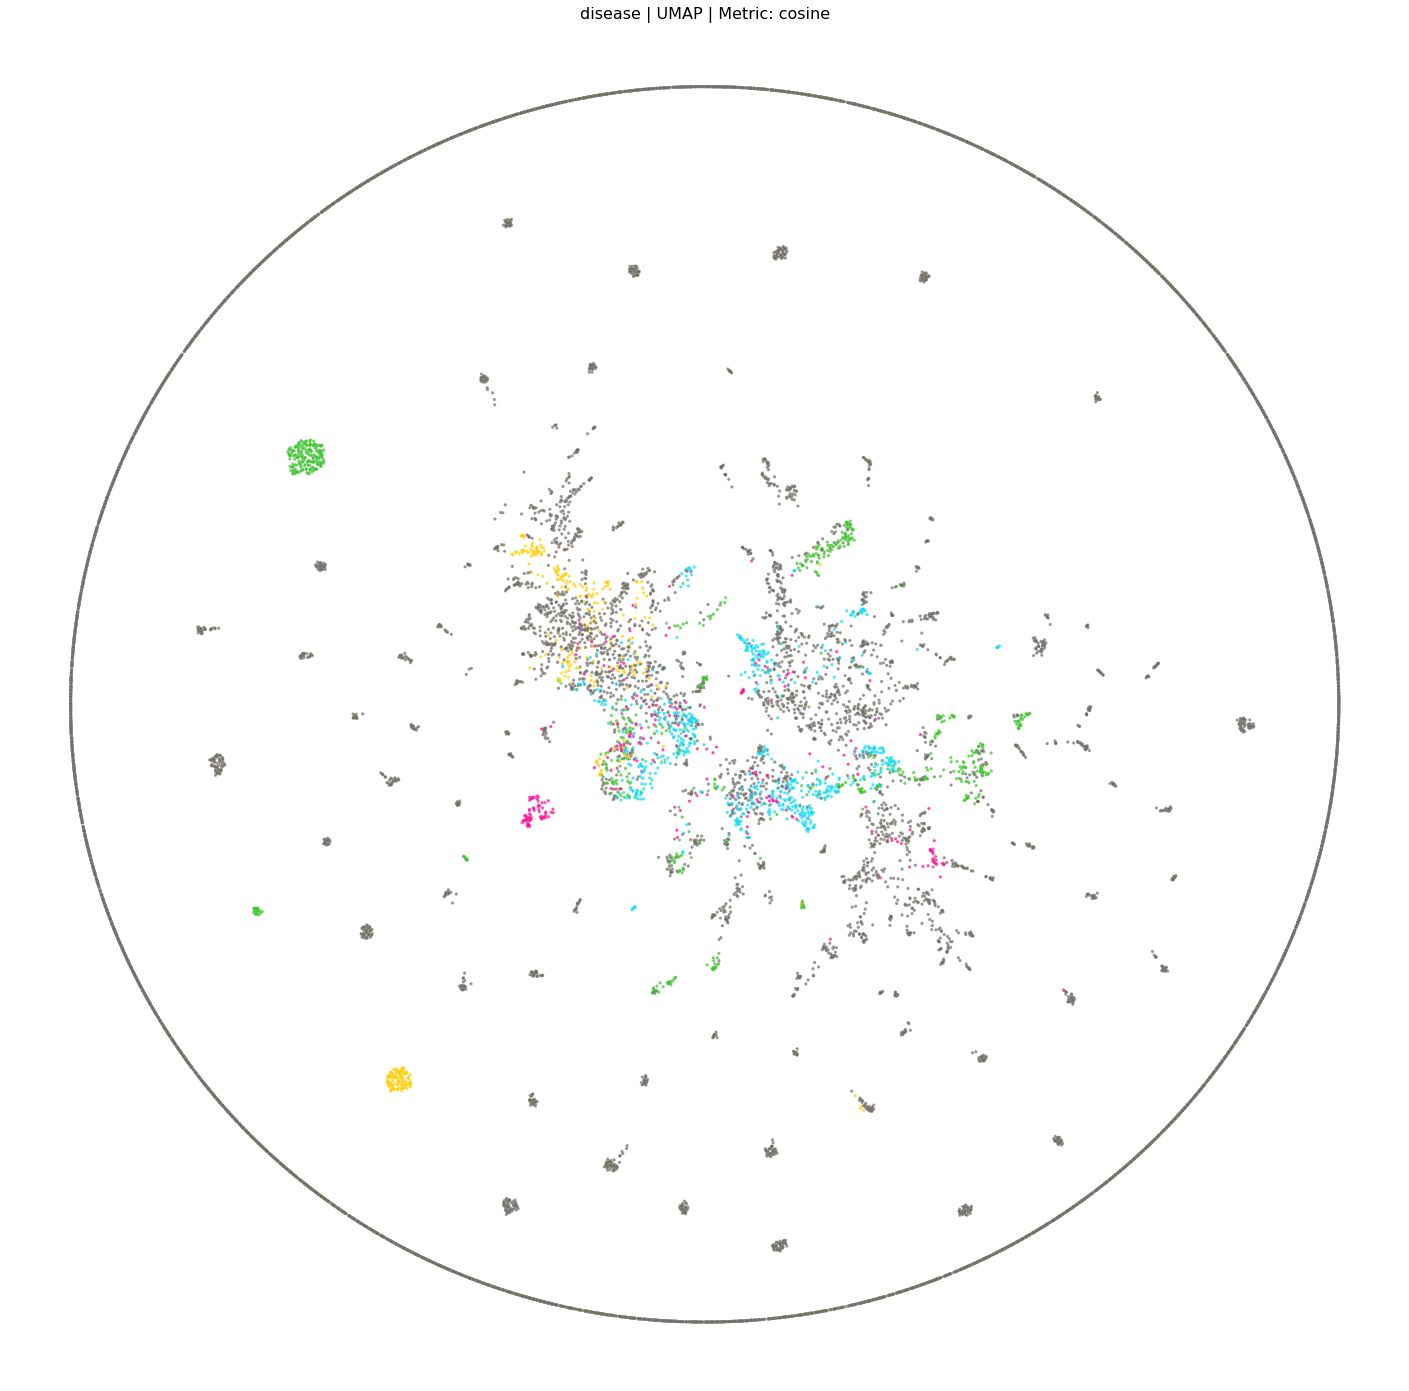

In [349]:
print('Color method: ', color_method)

plt.figure(figsize=(25,25))
plt.title(feature+' | UMAP | Metric: '+metric, size=16)

nx.draw_networkx_nodes(G, 
                       posG_complete_umap_norm,
                       edgecolors = node_edge_col, 
                       linewidths = 0.1, 
                       node_color = colours, 
                       node_size = 10.0, #size, #1.0,
                       alpha = opacity_nodes)

plt.box(False)
plt.savefig('output_plots/2DPortraitumap_'+feature+'_'+color_method+'_'+str(n_neighbors)+'_'+str(spread)+'_'+str(min_dist)+'_'+organism+'_noedges.png',dpi=300)
plt.show()

#### for specific edges ONLY

In [402]:
print('Color method: ', color_method)

trace2D_nodes = get_trace_nodes_2D(posG_complete_umap_norm, l_features, colours, 
                                   1) #size3d) 
#trace2D_edges_spec = get_trace_edges_from_genelist2D_(list(d_edge_col_.keys()), posG_complete_umap_norm, node_col, 0.1)

data = [#trace2D_edges_spec,
    trace2D_nodes]
path = 'output_plots/'
fname = '2Dportrait'+feature+'_'+color_method+'_'+str(n_neighbors)+'_'+str(spread)+'_'+str(min_dist)+'_'+organism+'_nodegree_specificedges'

plot_2D(data,path,fname)

Color method:  fourdiseases


#### UMAP EXPORT TO CSV

In [350]:
export_to_csv2D('C_2DPortrait'+organism+'_20210406', posG_complete_umap_norm, colours)

___
## LANDSCAPES
___

### Define z-parameter
+ Choose one of the following
___________

#### ------ ESSENTIAL ------

In [366]:
z_feat = 'ess'

value_ess = 10
value_noness = 5
value_undefined = 0

d_ess = z_landscape_essentiality(G, essential_genes, non_ess_genes, value_ess, value_noness, value_undefined)
z_list = list(d_ess.values())
z_list_norm = sklearn.preprocessing.minmax_scale(z_list, feature_range=(0, 1.0), axis=0, copy=True)

#### ------ Centrality Metrics average ------

In [360]:
z_feat = 'centraverage'

d_centr = {}
for i,j in df_centralities.iterrows():
    #d_centr[str(i)] = (j[0]+j[1]+j[2]+j[3])/4))
    d_centr[str(i)] = (j[0]+j[1]+j[2])/3 # without eigenvalue
    
dict_z  = {key:d_centr[key] for key in G.nodes()}

z_list = list(dict_z.values())
z_list_norm = sklearn.preprocessing.minmax_scale(z_list, feature_range=(0, 1.0), axis=0, copy=True)

#### ------ Disease count ------

In [363]:
z_feat = 'disease'

#DM_feature = DM_Disease
feat_matrix = pd.read_csv('_output_csv/Features_Disease_Dataframe_Human.csv', index_col=0)
DM_feature = feat_matrix

# set gene list (= G.nodes())
genes_assoc = []
for i in DM_feature.index:
    genes_assoc.append(str(i))
    
genes_notassoc = [] 
for g in G.nodes():
    if g not in genes_assoc:
        genes_notassoc.append(g)

features_counted = (feat_matrix == 1).astype(int).sum(axis=1)
d_features_counted = dict(zip(genes_assoc, list(features_counted)))
        
d_rest = {}
for i in genes_notassoc: 
    d_rest[i] = -20

d_param_unsorted = {**d_features_counted, **d_rest}
dict_z = {key:d_param_unsorted[key] for key in G.nodes()}

z_list = list(dict_z.values())
z_list_norm = sklearn.preprocessing.minmax_scale(z_list, feature_range=(0, 1), axis=0, copy=True)

#### ------ GO term count ------

In [370]:
z_feat = 'zGObio'

feat_matrix = pd.read_csv('_output_csv/Features_GO_BiolProc_Dataframe_Human.csv', index_col=0)
DM_feature = feat_matrix

# set gene list (= G.nodes())
genes_assoc = []
for i in DM_feature.index:
    genes_assoc.append(str(i))
    
genes_notassoc = [] 
for g in G.nodes():
    if g not in genes_assoc:
        genes_notassoc.append(g)

features_counted = (feat_matrix == 1).astype(int).sum(axis=1)
d_features_counted = dict(zip(genes_assoc, list(features_counted)))
        
d_rest = {}
for i in genes_notassoc: 
    d_rest[i] = -20

d_param_unsorted = {**d_features_counted, **d_rest}
dict_z = {key:d_param_unsorted[key] for key in G.nodes()}

z_list = list(dict_z.values())
z_list_norm = sklearn.preprocessing.minmax_scale(z_list, feature_range=(0, 1), axis=0, copy=True)

________

## UMAP

In [371]:
posG_land_umap = {}
cc = 0
for k,v in posG_complete_umap_norm.items():
    posG_land_umap[k] = (v[0],v[1],z_list_norm[cc])
    cc+=1

-----------------------
### CHOOSE UMAP CLUSTER Colors
+ for more information : https://umap-learn.readthedocs.io/en/latest/clustering.html

+ SPECTRAL CLUSTERING 

In [158]:
n_clus_spectral = 30
color_method = 'spectral'+str(n_clus_spectral)
colours = list(colours_spectralclustering(G, posG_land_umap, n_clus=n_clus_spectral, n_comp=10, pal='gist_rainbow').values())

/Users/chris/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



+ KMEANS

In [269]:
n_clus_kmeans = 20
color_method = 'kmeans'+str(n_clus_kmeans)

kmeans_, centrs = kmeansclustering(posG_umap, n_clus_kmeans)
colours = list(colours_kmeansclustering(G, DM, kmeans_, pal='gist_rainbow').values())

# annotation of clusters
#annot_light = annotation_kmeansclustering(kmeans_, centrs, 'light')
#annot_dark = annotation_kmeansclustering(kmeans_, centrs, 'dark')

+ DBSCAN
+ https://towardsdatascience.com/dbscan-algorithm-complete-guide-and-application-with-python-scikit-learn-d690cbae4c5d


In [265]:
color_method = 'dbscan'
epsi = 0.01 # eps = Density at a point P: Number of points within a circle of Radius Eps (ϵ) from point P
min_sam = 1 # MinPts = Dense Region: For each point in the cluster, the circle with radius ϵ contains at least minimum number of points (MinPts)
colours = list(colours_dbscanclustering(G, DM,
                                        posG_land_umap, 
                                        #posG_complete_umap_norm,
                                        epsi, min_sam, pal ='Set1').values())

Number of Clusters:  3255


-------------------

# PRINT Landscape

In [368]:
print('Color method: ', color_method)

print('# Neighbours:', n_neighbors)
print('Spread:',spread)
print('Min. Distance:', min_dist)

umap_nodes = get_trace_nodes_3D(posG_land_umap, l_features, colours, 
                                #size3d, 
                                1.5,
                                opacity_nodes)

umap_nodes_transparent = get_trace_nodes_3D(posG_land_umap, l_features, colours, 
                                nodesglow_diameter, nodesglow_transparency)                               

#umap_edges = get_trace_edges_3D(G, posG_land_umap, edge_colorlight)
#umap_edges = get_trace_spec_edges_only(list(d_edge_col.keys()), posG_land_umap, node_col)
#umap_data = [umap_edges, umap_nodes]
umap_data = [#umap_nodes_transparent, 
    umap_nodes]


data = umap_data
scheme = 'light'
# with edges: fname = 'output_plots/Landscapes_umap_'+feature+'_'+color_method+'_z-'+z_feat+'_'+metric+'_'+color_method+'_'+str(n_neighbors)+'_'+str(spread)+'_'+str(min_dist)+'_'+organism+'_withedges'
fname = 'output_plots/Landscapes_umap_'+feature+'_'+color_method+'_z-'+z_feat+'_'+metric+'_'+color_method+'_'+str(n_neighbors)+'_'+str(spread)+'_'+str(min_dist)+'_'+organism

plot_3D(data, fname, scheme)#, annot_light)

Color method:  fourdiseases
# Neighbours: 20
Spread: 5.0
Min. Distance: 0.9


'output_plots/Landscapes_umap_disease_fourdiseases_z-ess_cosine_fourdiseases_20_5.0_0.9_Human.html'

In [372]:
umap_nodes = get_trace_nodes_3D(posG_land_umap, l_features, colours, 
                                #size3d, 
                                1.5,
                                opacity_nodes)

umap_nodes_transparent = get_trace_nodes_3D(posG_land_umap, l_features, colours, 
                                nodesglow_diameter, nodesglow_transparency)                               

#umap_edges = get_trace_edges_3D(G, posG_land_umap, edge_colorlight)
#umap_edges_spec = get_trace_edges_from_genelist3D(list(d_edge_col_.keys()), posG_land_umap, node_col, 0.05)
#umap_data = [umap_edges, umap_nodes_transparent, umap_nodes]

umap_data = [#umap_edges_spec, umap_nodes_transparent, 
    umap_nodes]

data = umap_data
scheme = 'dark'

fname = 'output_plots/Landscapes_umap_'+feature+'_'+color_method+'_z-'+z_feat+'_'+metric+'_'+color_method+'_'+str(n_neighbors)+'_'+str(spread)+'_'+str(min_dist)+'_scheme'+scheme+'_'+organism

plot_3D(data, fname, scheme)#, annot_dark)

'output_plots/Landscapes_umap_disease_fourdiseases_z-GObioproc_cosine_fourdiseases_20_5.0_0.9_schemedark_Human.html'

#### UMAP LANDSCAPE EXPORT TO CSV

In [385]:
export_to_csv3D('C_Landscape'+organism+'_'+z_feat+'_20210406', posG_land_umap, colours)

____
## 3D PORTRAITS
____

## UMAP

In [376]:
%%time 

n_neighbors = 10 # balance between local and global structure in the data
spread = 10.0
min_dist = 0.0 # defines how dense points are stacked together 
metric='cosine'

umap_3D = embed_umap_3D(DM, n_neighbors, spread, min_dist, metric)
posG_3D_umap = get_posG_3D(genes, umap_3D)
posG_3D_complete_umap_norm = get_posG_3D_norm(G, DM, umap_3D)

/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



CPU times: user 39.2 s, sys: 896 ms, total: 40 s
Wall time: 10.7 s


-------------
### CHOOSE UMAP CLUSTER Colors
+ for more information : https://umap-learn.readthedocs.io/en/latest/clustering.html

+ SPECTRAL CLUSTERING 

In [ ]:
n_clus_spectral = 30
color_method = 'spectral'+str(n_clus_spectral)
colours = list(colours_spectralclustering(G, posG_3D_umap, n_clus=n_clus_spectral, n_comp=10, pal='gist_rainbow').values())

+ KMEANS

In [622]:
n_clus_kmeans = 30
color_method = 'kmeans'+str(n_clus_kmeans)

kmeans_, centrs = kmeansclustering(posG_3D_umap, n_clus_kmeans)
colours = list(colours_kmeansclustering(G, DM, kmeans_, pal='gist_rainbow').values())

# annotation of clusters
annot_light = annotation_kmeansclustering(kmeans_, centrs_norm, 'light')
annot_dark = annotation_kmeansclustering(kmeans_, centrs_norm, 'dark')

In [621]:
x_list = []
y_list = []
z_list = []
for v in centrs:
    x_list.append(v[0])
    y_list.append(v[1])
    z_list.append(v[2])
    
xx_norm = sklearn.preprocessing.minmax_scale(x_list, feature_range=(0, 1), axis=0, copy=True)
yy_norm = sklearn.preprocessing.minmax_scale(y_list, feature_range=(0, 1), axis=0, copy=True)
zz_norm = sklearn.preprocessing.minmax_scale(z_list, feature_range=(0, 1), axis=0, copy=True)

centrs_norm = list(zip(xx_norm,yy_norm,zz_norm))

+ DBSCAN
+ https://towardsdatascience.com/dbscan-algorithm-complete-guide-and-application-with-python-scikit-learn-d690cbae4c5d


In [ ]:
color_method = 'dbscan'
epsi = 1 # eps = Density at a point P: Number of points within a circle of Radius Eps (ϵ) from point P
min_sam = 10 # MinPts = Dense Region: For each point in the cluster, the circle with radius ϵ contains at least minimum number of points (MinPts)
colours = list(colours_dbscanclustering(G, DM, posG_3D_umap, epsi, min_sam, pal ='Set1').values())

# PRINT 3D Portrait

In [377]:
print('Color method: ', color_method)

print('# Neighbours:', n_neighbors)
print('Spread:',spread)
print('Min. Distance:', min_dist)

umap_nodes = get_trace_nodes_3D(posG_3D_complete_umap_norm, l_features, colours, 
                                2.0,
                                #size3d, 
                                opacity_nodes)
umap_nodes_transparent = get_trace_nodes_3D(posG_3D_complete_umap_norm, l_features, colours, nodesglow_diameter, nodesglow_transparency)                               
umap_data = [#umap_nodes_transparent, 
    umap_nodes]

#all edges:
#umap_edges = get_trace_edges_3D(G, posG_3D_complete_umap_norm, edge_colorlight, opac=0.2, linewidth=0.5)
#umap_data_edges = [umap_edges, umap_nodes_transparent, umap_nodes]

#specific edges:
#umap_edges_spec = get_trace_edges_from_genelist3D(list(d_edge_col_.keys()), posG_3D_complete_umap_norm, node_col, 0.1)
#umap_data_edges_spec = [umap_edges_spec, umap_nodes_transparent, umap_nodes]

scheme = 'light'

data_edges = umap_data
fname_edges = 'output_plots/3Dportrait_umap_'+feature+'_'+color_method+'_'+str(n_neighbors)+'_'+str(spread)+'_'+str(min_dist)+'_'+organism+'_'+scheme
plot_3D(data_edges, fname_edges, scheme) #, annot_light)

#data = umap_data_edges
#fname = 'output_plots/3Dportrait_umap_'+feature+'_'+color_method+'_'+str(n_neighbors)+'_'+str(spread)+'_'+str(min_dist)+'_'+organism+'_'+scheme+'_edges'
#plot_3D(data, fname, scheme) #, annot_light)

Color method:  fourdiseases
# Neighbours: 10
Spread: 10.0
Min. Distance: 0.0


'output_plots/3Dportrait_umap_disease_fourdiseases_10_10.0_0.0_Human_light_edges.html'

In [387]:
print('Color method: ', color_method)

print('# Neighbours:', n_neighbors)
print('Spread:',spread)
print('Min. Distance:', min_dist)

umap_nodes = get_trace_nodes_3D(posG_3D_complete_umap_norm, l_features, colours, 
                                1.5,
                                #size3d, 
                                opacity_nodes)
umap_nodes_transparent = get_trace_nodes_3D(posG_3D_complete_umap_norm, l_features, colours, nodesglow_diameter, nodesglow_transparency)                               
umap_data = [umap_nodes_transparent, umap_nodes]

#all edges:
umap_edges = get_trace_edges_3D(G, posG_3D_complete_umap_norm, edge_colordark, opac=0.1)
umap_data_edges = [umap_edges, umap_nodes_transparent, umap_nodes]

#specific edges:
#umap_edges_spec = get_trace_edges_from_genelist3D(list(d_edge_col_.keys()), posG_3D_complete_umap_norm, node_col, 0.25)
#umap_data_edges_spec = [umap_edges_spec, umap_nodes_transparent, umap_nodes]

scheme = 'dark'

data = umap_data_edges
fname = 'output_plots/3Dportrait_umap_'+feature+'_'+color_method+'_'+str(n_neighbors)+'_'+str(spread)+'_'+str(min_dist)+'_'+organism+'_'+scheme
plot_3D(data, fname, scheme)

#data_edges = umap_data_edges
#fname_edges = 'output_plots/3Dportrait_umap_'+feature+'_'+color_method+'_'+str(n_neighbors)+'_'+str(spread)+'_'+str(min_dist)+'_'+organism+'_'+scheme+'_edges'
#plot_3D(data_edges, fname_edges, scheme) #, annot_dark)

Color method:  fourdiseases
# Neighbours: 10
Spread: 10.0
Min. Distance: 0.0


'output_plots/3Dportrait_umap_disease_fourdiseases_10_10.0_0.0_Human_dark.html'

#### UMAP PORTRAIT EXPORT Coordinates

In [21]:
# for yeast 
posG_mod = {}
for node_id,coords in posG_3D_complete_umap_norm.items():
    posG_mod[only_numerics(node_id)]=coords
    
export_to_csv3D('C_3DPortrait'+organism+'_20210406', posG_mod, colours)

In [381]:
export_to_csv3D('C_3DPortrait'+organism+'_20210406', posG_3D_complete_umap_norm, colours)

#### EXPORT EDGE LIST 

In [48]:
edges_int = []
for i in G.edges():
    edges_int.append([only_numerics(i[0]),only_numerics(i[1])])
    
filenam = '_VR_layouts/C_3DPortrait'+organism+'_20210406_edgelist.txt'

with open(filename, 'w') as output:
    for row in edges_int:
        output.write(str(row[0]+','+row[1]) + '\n')

----
## SPHERE
### Define r-parameter
+ Choose one
----

#### ------ Gene List ------

In [48]:
# gene list example : AUTOCORE 
#G_AC = nx.read_edgelist("input/autocore_edgelist.txt")
#genes_list = list(G_AC.nodes())
#rad_param = 'autocore'

# variants from DataDiVR paper: 
genes_list = [str(i) for i in list(variants['variants'])]
rad_param = 'variants'

small_rad = 1
mid_rad = 5
outershell_rad = 30

d_param = {}
for i in G.nodes():
    if str(i) in genes_list:
        d_param[str(i)] = small_rad
    elif i in seed_list:
        d_param[str(i)] = mid_rad 
    elif int(i) in DM.index:
        d_param[str(i)] = outershell_rad 
    #else:
    #    d_param[str(i)] = outershell_rad

# check how many shells of spheres there will be :
len(set(d_param.values()))

3

#### ------ GO TERM / no-GO TERM ------

In [631]:
rad_param = 'goterm'

small_rad = 3
outershell_rad = 5

d_param = {}
for i in G.nodes():
    if int(i) in DM.index:
        d_param[str(i)]=outershell_rad
    else:
        d_param[str(i)]=small_rad

# check how many shells of spheres there will be :
len(set(d_param.values()))

2

#### ------ Disease / no-Disease ------

In [708]:
rad_param = 'disease'

small_rad = 1
outershell_rad = 2

d_param = {}
for i in G.nodes():
    if int(i) in DM_Disease.index:
        d_param[str(i)]=small_rad
    else:
        d_param[str(i)]=outershell_rad

# check how many shells of spheres there will be :
len(set(d_param.values()))

2

#### ------ Essentiality ------

In [686]:
rad_param = 'essent'

small_rad = 1
outershell_rad = 5


d_ess_scores = {}
for k,e in d_gID_all.items():
    if e == 'E':
        d_ess_scores[k] = small_rad
    else:
        d_ess_scores[k] = outershell_rad

d_param = d_ess_scores

# check how many shells of spheres there will be :
len(set(d_param.values()))

2

#### ------Centrality metrics average ------

In [723]:
rad_param = 'centraverage'

d_centr = {}
for i,j in df_centralities.iterrows():
    d_centr[str(i)] = round((j[0]+j[1]+j[2]+j[3])/4,1)

d_param = {key:d_centr[key] for key in G.nodes()}

# check how many shells of spheres there will be :
len(set(d_param.values()))

5

______

## UMAP

In [57]:
%%time 

n_neighbors = 50 # balance between local and global structure in the data
spread = 1.0
min_dist = 0.0 # defines how dense points are stacked together 
metric='cosine'

umap_sphere = embed_umap_sphere(DM, n_neighbors, spread, min_dist, metric)

CPU times: user 9min 9s, sys: 6.89 s, total: 9min 16s
Wall time: 1min 29s


In [58]:
genes_rad = genes+genes_list+seed_list # function genes + "my gene list"

posG_sphere = get_posG_sphere(genes, umap_sphere)
posG_complete_sphere_norm = get_posG_sphere_norm(G, genes_rad, umap_sphere, d_param, 40)

-------------
### CHOOSE UMAP CLUSTER Colors
+ for more information : https://umap-learn.readthedocs.io/en/latest/clustering.html

+ SPECTRAL CLUSTERING 

In [ ]:
n_clus_spectral = 30
color_method = 'spectral'+str(n_clus_spectral)
colours = list(colours_spectralclustering(G, posG_sphere, n_clus=n_clus_spectral, n_comp=10, pal='gist_rainbow').values())

+ KMEANS

In [87]:
n_clus_kmeans = 20
color_method = 'kmeans'+str(n_clus_kmeans)

kmeans_, centrs = kmeansclustering(posG_sphere, n_clus_kmeans)
#colours = list(colours_kmeansclustering(G, DM, kmeans_, pal='gist_rainbow').values())

d_colours = colours_kmeansclustering(G, DM, kmeans_, pal='gist_rainbow')
colours = list(d_colours.values())

+ DBSCAN
+ https://towardsdatascience.com/dbscan-algorithm-complete-guide-and-application-with-python-scikit-learn-d690cbae4c5d


In [146]:
color_method = 'dbscan'
epsi = 0.05 # eps = Density at a point P: Number of points within a circle of Radius Eps (ϵ) from point P
min_sam = 10 # MinPts = Dense Region: For each point in the cluster, the circle with radius ϵ contains at least minimum number of points (MinPts)

d_colours = colours_dbscanclustering(G, DM, #posG_complete_sphere_norm,
                                     posG_sphere, 
                                     epsi,
                                     min_sam, pal ='gist_rainbow',
                                    col_rest = '#808080') # '#d3d3d3') #'#696969') #'#d3d3d3')
colours = list(d_colours.values())

Number of Clusters:  139


+ additional to Clustering - color specific genes 

In [147]:
d_colours_spec_genes = {}
for k,v in d_colours.items():
    if k in l_genes:
        d_colours_spec_genes[k]='#8b0000'
    elif k in seed_list:
        d_colours_spec_genes[k]='#FF4500'
    else:
        d_colours_spec_genes[k]=v

d_colours_spec_genes_sort = {key:d_colours_spec_genes[key] for key in G.nodes()}
colours = list(d_colours_spec_genes_sort.values())

--------------------

# PRINT Sphere

In [148]:
print('Color method: ', color_method)

print('# Neighbours:', n_neighbors)
print('Spread:',spread)
print('Min. Distance:', min_dist)

umap_nodes = get_trace_nodes_3D(posG_complete_sphere_norm, l_features, colours, 
                                1.0, 
                                #size3d,
                                opacity_nodes)

umap_nodes_transparent = get_trace_nodes_3D(posG_complete_sphere_norm, l_features, colours, nodesglow_diameter, nodesglow_transparency)
umap_data = [umap_nodes_transparent, umap_nodes]
#umap_data = [umap_nodes_transparent, umap_clustercenters_transparent, umap_nodes]

#all edges:
umap_edges = get_trace_edges_3D(G, posG_complete_sphere_norm, edge_colorlight, 0.05)
umap_data_edges = [umap_edges, umap_nodes_transparent, umap_nodes]

#specific edges:
umap_edges_spec = get_trace_edges_from_genelist3D(list(d_edge_col_.keys()),posG_complete_sphere_norm, node_col, 0.4)
umap_data_edges_spec = [umap_edges_spec,umap_nodes_transparent, umap_nodes]


scheme = 'dark'


#data = umap_data
#fname = 'output_plots/3Dsphere_umap_'+feature+'_'+color_method+'_'+str(n_neighbors)+'_'+str(spread)+'_'+str(min_dist)+'_'+organism+'_radius'+rad_param+'_'+scheme
#plot_3D(data, fname, scheme)
#plot_3D(data, fname, scheme, annot_clusters)
#plot_3D(data, fname, scheme, annotations_lightmode_genelist)
#plot_3D(data, fname, scheme, annotation_lightmode_genes)

data_edges = umap_data_edges_spec
fname_edges = 'output_plots/3Dsphere_umap_'+feature+'_'+color_method+'_'+str(n_neighbors)+'_'+str(spread)+'_'+str(min_dist)+'_'+organism+'_radius'+rad_param+'_edges_specific'+'_'+scheme
plot_3D(data_edges, fname_edges, scheme)#, annotations_lightmode)

#data_edges = umap_data_edges
#fname_edges = 'output_plots/3Dsphere_umap_'+feature+'_'+color_method+'_'+str(n_neighbors)+'_'+str(spread)+'_'+str(min_dist)+'_'+organism+'_radius'+rad_param+'_edges'+'_'+scheme
#plot_3D(data_edges, fname_edges, scheme)#, annotations_lightmode)

Color method:  dbscan
# Neighbours: 50
Spread: 1.0
Min. Distance: 0.0


'output_plots/3Dsphere_umap_bioproc_dbscan_50_1.0_0.0_Human_radiusvariants_edges_specific_dark.html'

In [149]:
print('Color method: ', color_method)

print('# Neighbours:', n_neighbors)
print('Spread:',spread)
print('Min. Distance:', min_dist)

umap_nodes = get_trace_nodes_3D(posG_complete_sphere_norm, l_features, colours, 
                                1.0, 
                                #size3d,
                                opacity_nodes)

umap_nodes_transparent = get_trace_nodes_3D(posG_complete_sphere_norm, l_features, colours, nodesglow_diameter, nodesglow_transparency)
umap_data = [umap_nodes_transparent, umap_nodes]
#umap_data = [umap_nodes_transparent, umap_clustercenters_transparent, umap_nodes]

#all edges:
umap_edges = get_trace_edges_3D(G, posG_complete_sphere_norm, edge_colorlight, 0.05)
umap_data_edges = [umap_edges, umap_nodes_transparent, umap_nodes]

#specific edges:
umap_edges_spec = get_trace_edges_from_genelist3D(list(d_edge_col_.keys()),posG_complete_sphere_norm, node_col, 0.1)
umap_data_edges_spec = [umap_edges_spec,umap_nodes_transparent, umap_nodes]


scheme = 'light'


#data = umap_data
#fname = 'output_plots/3Dsphere_umap_'+feature+'_'+color_method+'_'+str(n_neighbors)+'_'+str(spread)+'_'+str(min_dist)+'_'+organism+'_radius'+rad_param+'_'+scheme
#plot_3D(data, fname, scheme)
#plot_3D(data, fname, scheme, annot_clusters)
#plot_3D(data, fname, scheme, annotations_lightmode_genelist)
#plot_3D(data, fname, scheme, annotation_lightmode_genes)

data_edges = umap_data_edges_spec
fname_edges = 'output_plots/3Dsphere_umap_'+feature+'_'+color_method+'_'+str(n_neighbors)+'_'+str(spread)+'_'+str(min_dist)+'_'+organism+'_radius'+rad_param+'_edges_specific'+'_'+scheme
plot_3D(data_edges, fname_edges, scheme)#, annotations_lightmode)

#data_edges = umap_data_edges
#fname_edges = 'output_plots/3Dsphere_umap_'+feature+'_'+color_method+'_'+str(n_neighbors)+'_'+str(spread)+'_'+str(min_dist)+'_'+organism+'_radius'+rad_param+'_edges'+'_'+scheme
#plot_3D(data_edges, fname_edges, scheme)#, annotations_lightmode)

Color method:  dbscan
# Neighbours: 50
Spread: 1.0
Min. Distance: 0.0


'output_plots/3Dsphere_umap_bioproc_dbscan_50_1.0_0.0_Human_radiusvariants_edges_specific_light.html'

#### UMAP SPHERE EXPORT TO CSV

In [95]:
export_to_csv3D('C_Sphere_20210405', posG_complete_sphere_norm, colours)

### ---- ANNOTATION ------

In [70]:
# add Genes Annotation

# choose a gene list by gene symbol 
genesym_selection = ['DOCK2','EGFR']

d_genes = {}
for k,v in d_gene_sym.items(): #k = gene entrez id ; v = gene symbol
    if v in genesym_selection:
        d_genes[k] = v
        
posG_genelist = {}
for k,v in posG_complete_sphere_norm.items():
    for g in d_genes.keys():
        if k == g:
            posG_genelist[g] = v
            
            
posG_genes = posG_genelist
mod_dark = 'dark'
annotation_darkmode_genes = genes_annotation(posG_genes, d_genes, mode = mod_dark)

mod_light = 'light'
annotation_lightmode_genes = genes_annotation(posG_genes, d_genes, mode = mod_light)

### ---- KMEANS CLUSTERING (in progress) ------

In [732]:
#df_posG = pd.DataFrame(posG_complete_sphere_norm).T 
#df_posG = pd.DataFrame(posG_3Dsphere_radius).T 

df_posG = pd.DataFrame(posG_3Dsphere).T 

n_clus = 10
color_method = 'kmeans'+str(n_clus)

kmeans = KMeans(n_clusters=n_clus, random_state=0).fit(df_posG)
centrs = kmeans.cluster_centers_


# number of genes in each cluster ( used for annotation )
d_clus_genecount = dict(Counter(kmeans.labels_))
l_clus_genecount = list(d_clus_genecount.values())
    
# Colours by Clusters 
d_node_clusterid = dict(zip(genes, kmeans.labels_))
colours_unsort = color_nodes_from_dict_unsort(d_node_clusterid, color_method, palette = sns.color_palette("hls", len(set(kmeans.labels_))))

genes_val = [1]*len(genes_rest)
d_genes_rest = dict(zip(genes_rest, genes_val))
colours_rest = color_nodes_from_dict_same(G, d_genes_rest, restnodes_col) #'dimgrey')
colours_all = {**colours_rest, **colours_unsort}
colours_sorted = {key:colours_all[key] for key in G.nodes}
colours = list(colours_sorted.values())


# add cluster centers and highlight them in visualization 

posG_clustercentrs = dict(zip(d_clus_genecount.keys(),centrs))

d_clusterid_col = {}
for node,col in colours_unsort.items():
    for nod, clus in d_node_clusterid.items():
        if node == nod:
            d_clusterid_col[clus] = col
            
d_clusterid_col_sort = dict(collections.OrderedDict(sorted(d_clusterid_col.items())))

prelim = {}
for n,clu in d_node_clusterid.items():
    for no, rad in d_param.items():
        if n == no: 
            prelim[clu]=rad
            
posG_clustercentrs_radius = {}
for clu, rad in prelim.items():
    for c, coords in posG_clustercentrs.items():
        if clu == c:
            posG_clustercentrs_radius[c]=(coords[0]*rad, coords[1]*rad, coords[2]*rad)
            
clusterglow_diameter = 25.0
clusterglow_transparency = 0.05
colours_clusters = list(d_clusterid_col_sort.values())

umap_clustercenters_transparent = get_trace_nodes_3D(posG_clustercentrs_radius, None, colours_clusters , clusterglow_diameter, clusterglow_transparency)


# add Cluster Annotation

d_clusterid_coords = posG_clustercentrs_radius
mod = 'light'
d_genes_per_cluster = d_clus_genecount

annot_clusters = cluster_annotation(d_clusterid_coords, d_genes_per_cluster, mode = mod)

# ===============
# UNDER CONSTRUCTION 

### Cluster annotations based on disease / go term frequency / assoc. of most genes 

In [82]:
top_disease = ('disease')
top_goterm = ('go term')

In [182]:
# get groups of genes based on clusters

d_genegrouped = {} 
  
for key, value in d_node_clusterid.items(): 
    if value not in d_genegrouped: 
        d_genegrouped[value] = [key] 
    else: 
        d_genegrouped[value].append(key)

In [273]:
# get intersection of gene lists in disease and cluster groups

d1 = d_genegrouped
d2 = d_do_genes


# WORK IN PROGRESS 
d_cluster_intersect = {} 
for i in range(n_clus):
    intersect = [] 
    for clu,lst1 in d1.items():
        for doid, lst2 in d2.items():
            intersect.append((set(lst1) & set(lst2)))
    d_cluster_intersect[i] = intersect

In [ ]:
# check which DOID genelist shares most genes in one of the cluster genelists

### SPECIFIC COLORING FUNCTIONS

In [283]:
# TO DO  - color edges outgoing from those Hubs too!!!

In [295]:
# -------------------------------------------
# DETECTING BRIDGING NODES 
# and color them + their adjacent neighbours
# -------------------------------------------


# COLOURING betweenness / bridging nodes + all others in grey 

col_betw = 'darkblue'
col_betwneigh = 'mediumblue'

min_tres = 0.06

betw_nodes_col = {}
for k,v in d_betw.items():
    if v >= min_tres:
        betw_nodes_col[k] = col_betw
    else:
        betw_nodes_col[k] = 'lightgrey'


# COLOURING all neighbours of bridging nodes 

betw_neighbours = {}
betw_neigh =[]
for i in betw_nodes.keys():
    for edge in G.edges():
        if edge[0] == i:
            betw_neigh.append(edge[1])
        elif edge[1] == i:
            betw_neigh.append(edge[0])
        betw_neighbours[i] = betw_neigh
        
betw_neigh_col = {}
for key, value in betw_neighbours.items():
    for v in value:
        betw_neigh_col[v] = col_betwneigh
        
betw_all = {**betw_nodes_col, **betw_neigh_col}
betw_all_sorted = {key:betw_all[key] for key in G.nodes()}

In [296]:
# TO DO  - color edges outgoing from those Hubs too!!!

In [ ]:
# T H E O R Y 


# TO DO 


# -------------------------------------------
# DETECTING "PERIPHERAL / ISOLATED" HUBS 
# and color them + their adjacent neighbours
# -------------------------------------------


# check for low degree neighbours : 
neighbours_degs_filtered = {}
for k,v in neighbours_degs.items():
    if v <= 2:
        neighbours_degs_filtered[k] = v

In [ ]:
# V I S U A L 


# TO DO  
# - edge opacity 
# - node opacity 



# TO DO FOR WEBAPP 
# make gene list as input for the color functions 
# to choose like: (WEBAPP) 

# input gene list
# choose major color
# choose if neighbours shall also be coloured > then choose their color too

# opacity of nodes will be affected by that (most visible = major, least = none) 
# opcacity of edges !!!! 



# TO DO  : 
# - revive old hubs colouring function > where each hubs would come out as different color
# edge colouring there too ??? 

In [ ]:
# TOGGLE colour method: 

# ------------------
# HUB NODES 
# ------------------
color_method = 'hubs'
colours = list(hubs_all_sorted.values())


# ------------------
# PERIPHERAL HUB
# ------------------
#color_method = 'isol_hubs'



# ------------------
# BETWEENNESS NODES (bridging nodes)
# ------------------
#color_method = 'betw'
#colours = list(betw_all_sorted.values())

# ==============

# Sphere Colours based on Clusters

### UMAP CLUSTER Colors (Spectral)

In [1332]:
# SPECTRAL from sklearn
from sklearn.cluster import SpectralClustering

df_posG = pd.DataFrame(posG_3Dsphere_radius).T
genes = genes_new 

n_clus = 30
color_method = 'spectral'

model = SpectralClustering(n_clusters=n_clus,n_components = 3, affinity='nearest_neighbors')
clusterid = model.fit(df_posG)
d_node_clusterid = dict(zip(genes, clusterid.labels_))

#clusterid = model.fit_predict(df_posG)
#d_node_clusterid = dict(zip(genes, clusterid))

# colour parameter from cluster 
colours_unsort = color_nodes_from_dict_unsort(G, d_node_clusterid, color_method, palette = 'Set1')

genes_val = [1]*len(genes_rest)
d_genes_rest = dict(zip(genes_rest, genes_val))
colours_rest = color_nodes_from_dict_same(G, d_genes_rest, restnodes_col) #'dimgrey')

colours_all = {**colours_rest, **colours_unsort}

colours_sorted = {key:colours_all[key] for key in G.nodes}
colours = list(colours_sorted.values())

/Users/chris/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



### UMAP CLUSTER Colors (DBSCAN)

In [167]:
from sklearn.cluster import DBSCAN

color_method = 'dbscan'
df_posG = pd.DataFrame(posG_complete_sphere_norm).T

# eps = Density at a point P: Number of points within a circle of Radius Eps (ϵ) from point P
# MinPts = Dense Region: For each point in the cluster, the circle with radius ϵ contains at least minimum number of points (MinPts)
clustering = DBSCAN(eps=0.5, min_samples=10) 

clusterid = clustering.fit_predict(df_posG)

d_node_clusterid = dict(zip(genes_new, clusterid))

# colour parameter from cluster 
colours_unsort = color_nodes_from_dict_unsort(G, d_node_clusterid, color_method, palette = 'prism')

genes_val = [1]*len(genes_rest)
d_genes_rest = dict(zip(genes_rest, genes_val))
colours_rest = color_nodes_from_dict_same(G, d_genes_rest, restnodes_col) #'dimgrey')

colours_all = {**colours_rest, **colours_unsort}

colours_sorted = {str(key):colours_all[key] for key in G.nodes}
colours = list(colours_sorted.values())

### SOME OTHER THINGS

Disease:  cancer


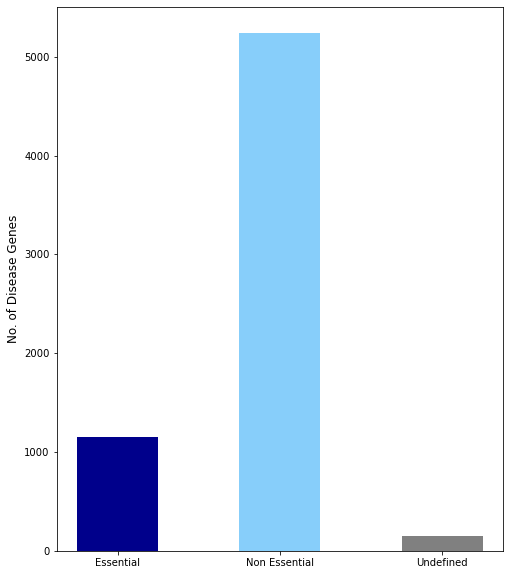

In [1088]:
# Diagrams for ESSENTIALITY 
# how many cances genes are essential, non-essential, undefined

print('Disease: ', disease_category)
disease_ess = []
disease_noness = []
disease_undef = []
for g in genes:
    if g in essential_genes:
        disease_ess.append(g)
    elif g in non_ess_genes:
        disease_noness.append(g)
    else:
        disease_undef.append(g)
        
categories = ['Essential', 'Non Essential', 'Undefined']
num_disease = [len(disease_ess), len(disease_noness), len(disease_undef)]
  
fig = plt.figure(figsize = (8,10))
 
# creating the bar plot
plt.bar(categories, num_disease, width=0.5, color=[essential_col,noessential_col, undefined_col])

plt.ylabel("No. of Disease Genes", fontsize=12)
plt.savefig('output_plots/Essentialgenes_Cancergenes.pdf',dpi=300)

plt.show()

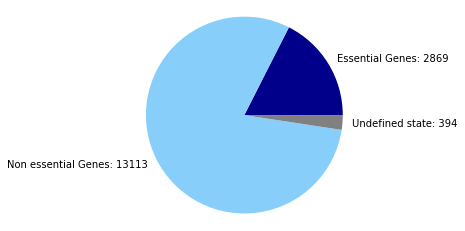

In [929]:
labels = 'Essential Genes: '+str(len(essential_genes)), 'Non essential Genes: '+str(len(non_ess_genes)), 'Undefined state: '+str(len(notdefined_genes))
sizes = [len(essential_genes), len(non_ess_genes), len(notdefined_genes)]
colors = [essential_col,noessential_col, undefined_col]
explode = (0.1, 0, 0, 0)  # explode 1st slice

# Plot
plt.pie(sizes, labels=labels, colors=colors)
plt.axis('equal')
plt.savefig('output_plots/Essentialgenes_pie.pdf',dpi=300)

plt.show()